In [1]:
import inspect # view the source code using ---> getsourcelines(thing)

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor

import random

In [2]:
print(f"PyTorch version: {torch.__version__}\ntorchvision version: {torchvision.__version__}")

PyTorch version: 1.10.2
torchvision version: 0.11.0a0


In [3]:
train_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
    target_transform=None,
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
    target_transform=None,
)

class_names = train_data.classes
print(class_names)

['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


In [4]:
len(train_data.data), len(test_data.data)

(60000, 10000)

In [5]:
# iterator example

for x in np.random.rand(5): print(x)

print(), print()

stuff = np.random.rand(5)
print(stuff), print()
it = iter(stuff)

while True:
    try:
        item = next(it)
        print(item)
    except StopIteration:
        print("StopIteration exception raised")
        break
        

stuff = np.random.rand(5)
print(), print(), print(stuff), print()
it = iter(stuff)

# this will raise exception
#while True:
#    item = next(it)
#    print(item)

0.04318702849673717
0.1476309610358829
0.6669926154486189
0.04825908063144135
0.8970135056603361


[0.4127643  0.33115894 0.7480925  0.53170551 0.31699828]

0.41276430326815206
0.331158939707239
0.7480925013586635
0.5317055053087284
0.31699827739609865
StopIteration exception raised


[0.27437058 0.19980547 0.56960279 0.38307068 0.24943066]



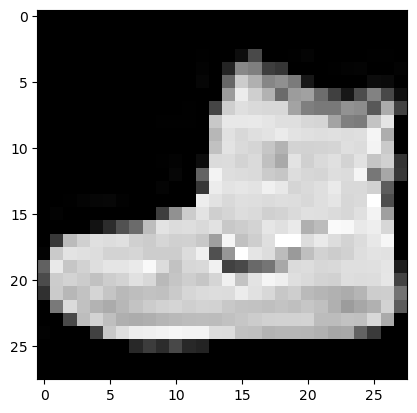

In [6]:
image, label = train_data[0]
image = image.detach().numpy()
plt.imshow(image.squeeze(), cmap="gray")

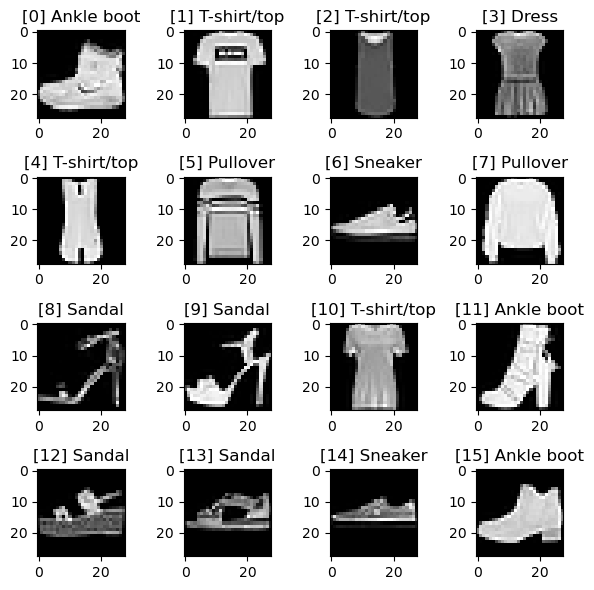

In [7]:
rows, cols = 4, 4
fig = plt.figure(figsize=(6,6))
for i in range(rows * cols):
    image, label = train_data[i]
    image = image.detach().numpy().squeeze()
    fig.add_subplot(rows, cols, i+1)
    plt.imshow(image, cmap="gray")
    plt.title(f"[{i}] {train_data.classes[label]}")
fig.tight_layout()

In [8]:
from torch.utils.data import DataLoader

# Setup the batch size hyperparameter
BATCH_SIZE = 32

# Turn datasets into iterables (batches)
train_dataloader = DataLoader(train_data, # dataset to turn into iterable
    batch_size=BATCH_SIZE, # how many samples per batch? 
    shuffle=True # shuffle data every epoch?
)

test_dataloader = DataLoader(test_data,
    batch_size=BATCH_SIZE,
    shuffle=False # don't necessarily have to shuffle the testing data
)

# Let's check out what we've created
print(f"Dataloaders: {train_dataloader, test_dataloader}") 
print(f"Length of train dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}")
print(f"Length of test dataloader: {len(test_dataloader)} batches of {BATCH_SIZE}")

Dataloaders: (<torch.utils.data.dataloader.DataLoader object at 0x144370be0>, <torch.utils.data.dataloader.DataLoader object at 0x144370d30>)
Length of train dataloader: 1875 batches of 32
Length of test dataloader: 313 batches of 32


In [9]:
a = iter(train_dataloader)

b[0] (batch of samples, length: 32)
Each sized: torch.Size([1, 28, 28])

b[1] (batch of labels, length: 32): 
tensor([8, 7, 2, 6, 5, 8, 9, 6, 8, 5, 0, 3, 2, 7, 7, 2, 6, 1, 1, 2, 4, 0, 5, 2,
        1, 3, 9, 7, 1, 0, 2, 1])

b[1][0] (current label: 8), type: <class 'numpy.ndarray'>


Text(0.5, 1.0, '8, Bag')

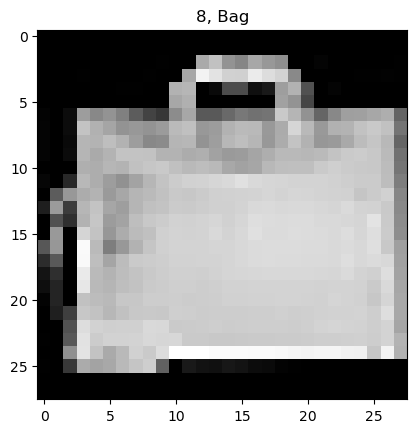

In [10]:
b = next(a)

print(f"b[0] (batch of samples, length: {len(b[0])})\nEach sized: {b[0][0].shape}\n")
print(f"b[1] (batch of labels, length: {len(b[1])}): \n{b[1]}\n")

# next(a)
# [0] (e.g. train_features_batch)
#    ---> array of tensors (X data),   length: batch size
# [1] (e.g. train_labels_batch)
#    ---> array of tensors (y labels), length: batch size

# second index: current sample in current batch

img = b[0][0].detach().numpy().squeeze()
lab = b[1][0].detach().numpy()
print(f"b[1][0] (current label: {lab}), type: {type(lab)}")

plt.imshow(img, cmap="gray")
plt.title(f"{lab}, {train_data.classes[lab]}")

In [11]:
train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

In [12]:
flatten_model = nn.Flatten()

x = train_features_batch[0]

output = flatten_model(x)

print(f"shape before flatten: {x.shape}      -> [colour channels, height, width]")
print(f"shape after flatten:  {output.shape} -> [colour channels, height*width]")

shape before flatten: torch.Size([1, 28, 28])      -> [colour channels, height, width]
shape after flatten:  torch.Size([1, 784]) -> [colour channels, height*width]


In [13]:
class FashionMNISTModelV0(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(), # will take 28x28 image and output 28*28 (784) vector
            nn.Linear(in_features=input_shape, out_features=hidden_units), # will take 784 vector as input (input_shape arg)
            nn.Linear(in_features=hidden_units, out_features=output_shape)
        )
        
    def forward(self, x):
        return self.layer_stack(x)

In [14]:
torch.manual_seed(42)

model_0 = FashionMNISTModelV0(input_shape=28*28, hidden_units=10, output_shape=len(class_names))
model_0.to("cpu")

FashionMNISTModelV0(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=10, bias=True)
  )
)

In [15]:
def accuracy_fn(y_pred, y_true):
    #prediction_index = y_pred.detach().numpy().argmax(axis=1)
    #true_index = y_true.detach().numpy()
    # must be converted before the function
    l = len(y_true)
    return np.sum(y_pred==y_true)/l

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.1)

In [16]:
test_batch = next(iter(test_dataloader))
test_batch_samples = test_batch[0]
test_batch_labels = test_batch[1]


print(len(test_batch))

model_0.eval()
with torch.inference_mode():
    
    preds = model_0(test_batch_samples)

    print(preds.shape)
    
    loss = loss_fn(preds, test_batch_labels)
    print(loss.item())
    
    acc = accuracy_fn(y_pred=preds.detach().numpy().argmax(axis=1), y_true=test_batch_labels.detach().numpy())
    print(acc)
    
preds_np = preds.detach().numpy().argmax(axis=1)
trues_np = test_batch_labels.detach().numpy()

print(preds_np.shape, trues_np.shape)
    
print(f"predictions: {preds_np}")

print(f"true vals  : {trues_np}")

print(f"accuracy   : {accuracy_fn(y_pred=preds_np, y_true=trues_np)}")
    



print(),print(),print()
preds = preds[0].detach().numpy().argmax()
print(preds)
labels = test_batch_labels[0].detach().numpy()
print(labels)



2
torch.Size([32, 10])
2.290891647338867
0.09375
(32,) (32,)
predictions: [2 6 6 4 4 6 7 4 2 6 4 2 7 4 4 4 4 6 6 4 4 7 6 6 4 7 4 6 6 4 1 1]
true vals  : [9 2 1 1 6 1 4 6 5 7 4 5 7 3 4 1 2 4 8 0 2 5 7 9 1 4 6 0 9 3 8 8]
accuracy   : 0.09375



2
9


In [17]:
epochs = 3

for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n----------")
    
    train_loss = 0
    
    # n_batch is the current batch
    # (X, y) since train_dataloader has 2 items - data and labels, both are tensor arrays
    for n_batch, (X, y) in enumerate(train_dataloader):
        
        y_pred = model_0(X)
        
        loss = loss_fn(y_pred, y)
        
        train_loss += loss # accumulate loss for each epoch
        
        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step()
        
        if n_batch % 400 == 0:
            print(f"Looked at {n_batch * len(X)}/{len(train_dataloader.dataset)} samples")
            
    train_loss /= len(train_dataloader) # get train loss percentage
    
    losses, accuracies = [], []
    test_loss, test_acc = 0, 0
    model_0.eval()
    with torch.inference_mode():
        for X, y in test_dataloader:
            test_pred = model_0(X)
            
            loss = loss_fn(test_pred, y)
            
            test_loss += loss
            
            test_acc += accuracy_fn(y_pred=test_pred.detach().numpy().argmax(axis=1), y_true=y.detach().numpy())
            #accuracies.append(test_acc)
            a = test_acc/len(test_dataloader)*100
            #print(a)
            accuracies.append(a)
        
            
        test_loss /= len(test_dataloader)
        test_acc /= len(test_dataloader)
        #accuracies.append(test_acc*100)

  0%|                                                                         | 0/3 [00:00<?, ?it/s]

Epoch: 0
----------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples


 33%|█████████████████████▋                                           | 1/3 [00:01<00:03,  1.92s/it]

Epoch: 1
----------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples


 67%|███████████████████████████████████████████▎                     | 2/3 [00:03<00:01,  1.92s/it]

Epoch: 2
----------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples


100%|█████████████████████████████████████████████████████████████████| 3/3 [00:05<00:00,  1.91s/it]


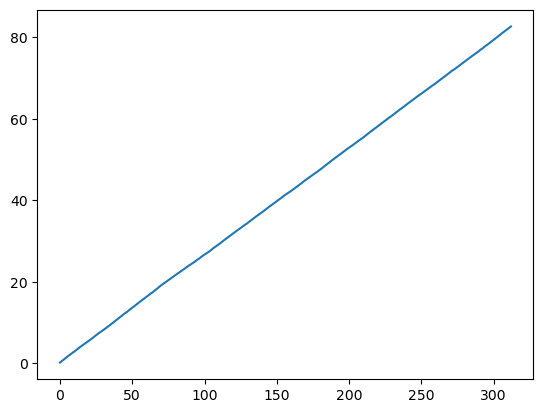

In [18]:
plt.plot(accuracies)

In [19]:
print(test_acc*100) # accuracy percentage
print(test_loss)

82.68769968051119
tensor(0.4861)


In [20]:
def eval_model(model: torch.nn.Module,
                data_loader: torch.utils.data.DataLoader, # samples & labels batches for testing
                loss_fn: torch.nn.Module,
                accuracy_fn,
                should_plot: bool):
    
    losses, accuracies = [], []
    
    model.eval()
    with torch.inference_mode():
        for X, y in data_loader:
            
            predictions = model(X)
            
            loss = loss_fn(predictions, y)
            losses.append(loss.item())
            
            acc = accuracy_fn(predictions.detach().numpy().argmax(axis=1), y.detach().numpy())*100
            accuracies.append(acc)           
    
    last_loss = losses[len(losses)-1]
    last_acc = accuracies[len(accuracies)-1]
    
    if should_plot:
        plt.plot(accuracies, c='b')
        plt.plot([*range(len(accuracies))], [np.mean(accuracies) for _ in range(len(accuracies))], c="r")
        plt.plot(np.exp(losses), c='g')
        plt.show()
        
        print(f"Loss: {last_loss}")
        print(f"Accuracy: {last_acc}")
    
    return {"model_name": model.__class__.__name__,
            "model_loss": last_loss,
            "model_accuracy": last_acc}

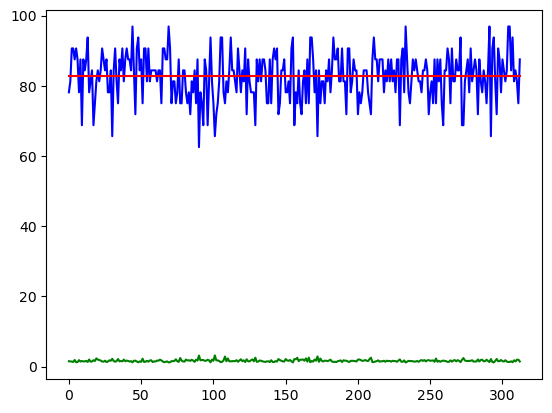

Loss: 0.37378525733947754
Accuracy: 87.5
{'model_name': 'FashionMNISTModelV0', 'model_loss': 0.37378525733947754, 'model_accuracy': 87.5}


In [21]:
loss_fn = nn.CrossEntropyLoss()
model_0_results = eval_model(model_0, test_dataloader, loss_fn, accuracy_fn, True)
print(model_0_results)

In [22]:
class FashionMNISTModelV1(nn.Module):
    def __init__(self, input_shape, hidden_units, output_shape):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=input_shape, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=output_shape),
            nn.ReLU()
        )
        
    def forward(self, x):
        return self.layer_stack(x)

In [23]:
def train_model(model: nn.Module,
                loss_fn,
                optimizer, 
                dataloader: torch.utils.data.DataLoader,
                n_epochs: int,
                batch_size: int):
  
    losses = []
    accuracies = []
    
    model.train()
    
    for epoch in tqdm(range(n_epochs)):
        
        print(f"Epoch: {epoch}/{n_epochs}---------------")
    
        for batch_n, (X, y) in enumerate(dataloader):
            
            if batch_n % 500 == 0: print(f"Batch: {batch_n}/{len(dataloader)}---------------")

            y_predictions = model(X)
            
            loss = loss_fn(y_predictions, y)
            losses.append(loss.item())

            acc = accuracy_fn(y_predictions.detach().numpy().argmax(axis=1), y.detach().numpy())*100
            accuracies.append(acc)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
                
    plt.plot(accuracies)
    plt.plot(np.exp(losses))
    plt.ylim(0, 100)
    plt.show()
    print(f"Accuracy: {accuracies[len(accuracies)-1]}")
    print(f"Loss: {losses[len(losses)-1]}")

In [24]:
model_1 = FashionMNISTModelV1(28*28, 10, len(class_names))

In [25]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_1.parameters(), lr=0.01)

  0%|                                                                         | 0/3 [00:00<?, ?it/s]

Epoch: 0/3---------------
Batch: 0/1875---------------
Batch: 500/1875---------------
Batch: 1000/1875---------------
Batch: 1500/1875---------------


 33%|█████████████████████▋                                           | 1/3 [00:01<00:03,  1.77s/it]

Epoch: 1/3---------------
Batch: 0/1875---------------
Batch: 500/1875---------------
Batch: 1000/1875---------------
Batch: 1500/1875---------------


 67%|███████████████████████████████████████████▎                     | 2/3 [00:03<00:01,  1.77s/it]

Epoch: 2/3---------------
Batch: 0/1875---------------
Batch: 500/1875---------------
Batch: 1000/1875---------------
Batch: 1500/1875---------------


100%|█████████████████████████████████████████████████████████████████| 3/3 [00:05<00:00,  1.76s/it]


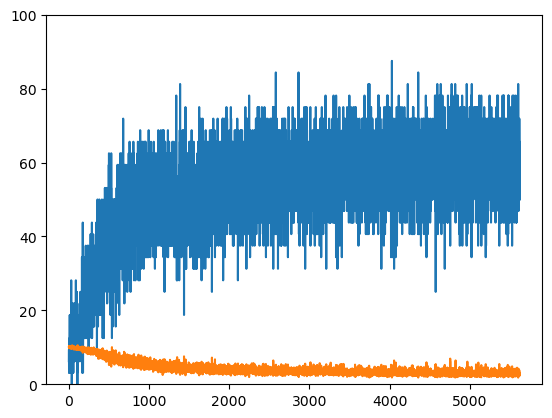

Accuracy: 50.0
Loss: 1.0186432600021362


In [26]:
train_model(model_1, loss_fn, optimizer, train_dataloader, 3, 32)

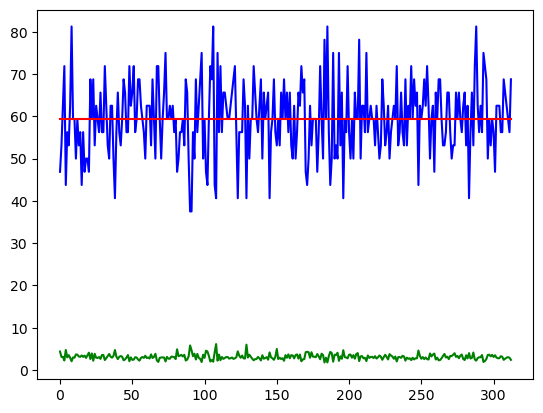

Loss: 0.870368242263794
Accuracy: 68.75


{'model_name': 'FashionMNISTModelV1',
 'model_loss': 0.870368242263794,
 'model_accuracy': 68.75}

In [27]:
model_1_results = eval_model(model_1, test_dataloader, loss_fn, accuracy_fn, True)
model_1_results

In [28]:
model_0_results

{'model_name': 'FashionMNISTModelV0',
 'model_loss': 0.37378525733947754,
 'model_accuracy': 87.5}

In [29]:
class FashionMNISTModelV2(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        
        self.block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=3, # how big is the window going over the image
                      stride=1,      # default
                      padding=1),    # # options = "valid" (no padding) or "same" (output has same shape as input) or int for specific number 
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2)
        )
        
        self.block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units, 
                      out_channels=hidden_units,
                      kernel_size=3,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*7*7,
                      out_features=output_shape)
        )
    
    def forward(self, x: torch.Tensor):
        x = self.block_1(x) #x.shape = torch.Size([32, 10, 14, 14])
        x = self.block_2(x) #x.shape = torch.Size([32, 10, 7, 7])
        x = self.classifier(x) #x.shape = torch.Size([32, 10])
        return x

In [30]:
model_2 = FashionMNISTModelV2(input_shape=1,
                              hidden_units=10,
                              output_shape=len(class_names))
model_2

FashionMNISTModelV2(
  (block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

In [31]:
test_batch = next(iter(test_dataloader))
test_batch_samples = test_batch[0]
test_batch_labels = test_batch[1]

print(len(test_batch))

model_2.eval()
with torch.inference_mode():
    
    preds = model_2(test_batch_samples)
    
    preds_np = preds.detach().numpy()
    print(f"Test predictions: {preds_np.argmax(axis=1)}")  
    print(f"Test labels     : {test_batch_labels.detach().numpy()}")
    
    loss = loss_fn(preds, test_batch_labels)
    print(f"Loss: {loss.item()}")
    
    acc = accuracy_fn(y_pred=preds_np.argmax(axis=1),y_true=test_batch_labels.detach().numpy())*100
    print(f"Accuracy: {acc}")


2
Test predictions: [7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
Test labels     : [9 2 1 1 6 1 4 6 5 7 4 5 7 3 4 1 2 4 8 0 2 5 7 9 1 4 6 0 9 3 8 8]
Loss: 2.2966806888580322
Accuracy: 9.375


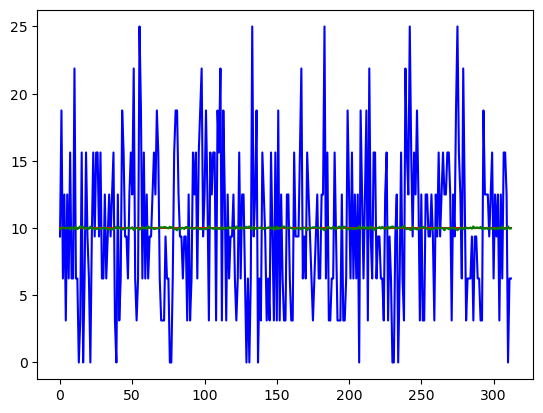

Loss: 2.3004488945007324
Accuracy: 6.25


{'model_name': 'FashionMNISTModelV2',
 'model_loss': 2.3004488945007324,
 'model_accuracy': 6.25}

In [32]:
eval_model(model_2, test_dataloader, loss_fn, accuracy_fn, True)
            

In [172]:
# getting a better understanding of dimensionality
# represented in numpy arrays

x = np.arange(200, dtype=np.float32)
print(f"Numpy arange: {x}")
print(f"Numpy arange (16) shape: {x.shape}\n\n")

x = x.reshape(2, 4, 5, 5)  # bs, channels, height, width
print(f"Arange size 16 after reshape:\n{x}")
print(f"Numpy arange after reshape: {x.shape}\n\n")

print(), print()

# x[0] is the "first" group of matrices
for g in range(2):
    for a, i in enumerate(x[g]):
        print(a, i[2][2], i.shape)

# intuitively: reshape(a, b, c, d)
# a = number of groups of matrices
# b = number of matrices in each group
# x size of each matrix
# y size of each matrix

# above example:
# 1 group of 4 matrices, sized 5x5

Numpy arange: [  0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.
  42.  43.  44.  45.  46.  47.  48.  49.  50.  51.  52.  53.  54.  55.
  56.  57.  58.  59.  60.  61.  62.  63.  64.  65.  66.  67.  68.  69.
  70.  71.  72.  73.  74.  75.  76.  77.  78.  79.  80.  81.  82.  83.
  84.  85.  86.  87.  88.  89.  90.  91.  92.  93.  94.  95.  96.  97.
  98.  99. 100. 101. 102. 103. 104. 105. 106. 107. 108. 109. 110. 111.
 112. 113. 114. 115. 116. 117. 118. 119. 120. 121. 122. 123. 124. 125.
 126. 127. 128. 129. 130. 131. 132. 133. 134. 135. 136. 137. 138. 139.
 140. 141. 142. 143. 144. 145. 146. 147. 148. 149. 150. 151. 152. 153.
 154. 155. 156. 157. 158. 159. 160. 161. 162. 163. 164. 165. 166. 167.
 168. 169. 170. 171. 172. 173. 174. 175. 176. 177. 178. 179. 180. 181.
 182. 183. 184. 185. 186. 187. 188. 189. 190. 191. 192. 193. 19

In [174]:
x = np.arange(32, dtype=np.float32)
print(f"Numpy arange: {x}")
print(f"Numpy arange (16) shape: {x.shape}\n\n")

x = x.reshape(1, 2, 4, 4)  # bs, channels, height, width
print(f"Arange size 16 after reshape:\n{x}")
print(f"Numpy arange after reshape: {x.shape}\n")

X = torch.tensor(x, dtype=torch.float32).to("cpu")
print("\nSource input: ")
print(X)

pool1 = nn.MaxPool2d(2, stride=1)
z1 = pool1(X)
print("\nMaxPool with kernel=2, stride=1: ")
print(z1)

pool2 = nn.MaxPool2d(2, stride=2)
z2 = pool2(X)
print("\nMaxPool with kernel=2, stride=2: ")
print(z2)

print("\nEnd max pooling demo ")

Numpy arange: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31.]
Numpy arange (16) shape: (32,)


Arange size 16 after reshape:
[[[[ 0.  1.  2.  3.]
   [ 4.  5.  6.  7.]
   [ 8.  9. 10. 11.]
   [12. 13. 14. 15.]]

  [[16. 17. 18. 19.]
   [20. 21. 22. 23.]
   [24. 25. 26. 27.]
   [28. 29. 30. 31.]]]]
Numpy arange after reshape: (1, 2, 4, 4)


Source input: 
tensor([[[[ 0.,  1.,  2.,  3.],
          [ 4.,  5.,  6.,  7.],
          [ 8.,  9., 10., 11.],
          [12., 13., 14., 15.]],

         [[16., 17., 18., 19.],
          [20., 21., 22., 23.],
          [24., 25., 26., 27.],
          [28., 29., 30., 31.]]]])

MaxPool with kernel=2, stride=1: 
tensor([[[[ 5.,  6.,  7.],
          [ 9., 10., 11.],
          [13., 14., 15.]],

         [[21., 22., 23.],
          [25., 26., 27.],
          [29., 30., 31.]]]])

MaxPool with kernel=2, stride=2: 
tensor([[[[ 5.,  7.],
          [13., 15.]],

         [[21., 2

In [233]:
images = torch.randn(size=(32, 3, 64, 64)) # [batch_size, color_channels, height, width]
test_image = images[0] # first "group" of 3 channels (colours) of 64x64 pixels

conv_layer = nn.Conv2d(in_channels=3,
                       out_channels=10,
                       kernel_size=3,
                       stride=1,
                       padding=0)

# unsqueeze(dim=0) adds an extra dimension
print(test_image.shape) # original shape
print(test_image.unsqueeze(dim=0).shape) # shape with extra dimension (its' own group)

print(), print()

print(test_image.shape) # original shape
output = conv_layer(test_image.unsqueeze(dim=0)) # output of conv layer
output.shape # output shape
#print(output)

torch.Size([3, 64, 64])
torch.Size([1, 3, 64, 64])


torch.Size([3, 64, 64])


torch.Size([1, 10, 62, 62])

In [253]:
conv_layer_2 = nn.Conv2d(in_channels=3,
                         out_channels=10,
                         kernel_size=(2,2),
                         stride=2.
                         padding=0)


conv_layer_2(test_image.unsqueeze(dim=0)).shape

torch.Size([1, 10, 32, 32])

In [237]:
# Get shapes of weight and bias tensors within conv_layer_2
print(f"conv_layer_2 weight shape: \n{conv_layer_2.weight.shape} -> [out_channels=10, in_channels=3, kernel_size=5, kernel_size=5]")
print(f"\nconv_layer_2 bias shape: \n{conv_layer_2.bias.shape} -> [out_channels=10]")

conv_layer_2 weight shape: 
torch.Size([10, 3, 5, 5]) -> [out_channels=10, in_channels=3, kernel_size=5, kernel_size=5]

conv_layer_2 bias shape: 
torch.Size([10]) -> [out_channels=10]


In [374]:
torch.manual_seed(42)

# getting a better understanding of the convolutional 2d layer in torch
# example using a 2x2 matrix, with a single digit kernel

a = np.arange(4).reshape(2,2)
a = torch.from_numpy(a.astype(np.float32)).unsqueeze(dim=0).unsqueeze(dim=1)
b = nn.Conv2d(in_channels=1,out_channels=1,kernel_size=(1),stride=1,padding=0)

print("---- Original tensor ----")
print(a.shape), print(a), print()

output = b(a)
print("---- New tensor (OUTPUT) ----")
print(output.shape), 
print(output)

print(),print()

print("---- Conv2d layer ----")
print("Weight:")
print(b.weight.shape)
print(b.weight)
print()
print("Bias:")
print(b.bias)

print(),print()
for i in range(2):
    print(f"index {i}: {a[0,0,0,i].detach().numpy()} * {b.weight.detach().numpy().squeeze()} + {b.bias.detach().numpy().squeeze()} = {(a[0,0,0,i] * b.weight + b.bias).detach().numpy().squeeze()}")
    
for i in range(2):
    print(f"index {2 + i}: {a[0,0,1,i].detach().numpy()} * {b.weight.detach().numpy().squeeze()} + {b.bias.detach().numpy().squeeze()} = {(a[0,0,1,i] * b.weight + b.bias).detach().numpy().squeeze()}")

print(f"compared to output: \n{output.detach().numpy()}")
print(), print()


print("Equals the same as the output")
print()
print("Conv2d layer will multiply its' own randomly initialised weights")
#print("If the kernel size is bigger

---- Original tensor ----
torch.Size([1, 1, 2, 2])
tensor([[[[0., 1.],
          [2., 3.]]]])

---- New tensor (OUTPUT) ----
torch.Size([1, 1, 2, 2])
tensor([[[[0.8300, 1.5945],
          [2.3591, 3.1236]]]], grad_fn=<SlowConv2DBackward0>)


---- Conv2d layer ----
Weight:
torch.Size([1, 1, 1, 1])
Parameter containing:
tensor([[[[0.7645]]]], requires_grad=True)

Bias:
Parameter containing:
tensor([0.8300], requires_grad=True)


index 0: 0.0 * 0.7645385265350342 + 0.8300079107284546 = 0.8300079107284546
index 1: 1.0 * 0.7645385265350342 + 0.8300079107284546 = 1.5945464372634888
index 2: 2.0 * 0.7645385265350342 + 0.8300079107284546 = 2.3590850830078125
index 3: 3.0 * 0.7645385265350342 + 0.8300079107284546 = 3.1236233711242676
compared to output: 
[[[[0.8300079 1.5945464]
   [2.359085  3.1236234]]]]


Equals the same as the output

Conv2d layer will multiply its' own randomly initialised weights


In [551]:
torch.manual_seed(42)
print("Improving my understanding of the Conv2d layer in torch.")
print("This example demonstrates the calculation of the Conv2d layer,\
\nwhich in this case has a kernel_size matching the input size.")



a = np.arange(4).reshape(2,2)
a = torch.from_numpy(a.astype(np.float32)).unsqueeze(dim=0).unsqueeze(dim=1)
a.requires_grad = False
b = nn.Conv2d(in_channels=1,out_channels=1,kernel_size=((2,2)),stride=1,padding=0)
print(f"\n{b}\n")

print("---- Original tensor ----")
print(a.shape), print(a), print()

output = b(a)
print("---- New tensor (OUTPUT) ----")
print(output.shape), 
print(output)

print(),print()

print("---- Conv2d layer ----")
print("Weight:")
print(b.weight.shape)
print(b.weight)
print()
print("Bias:")
print(b.bias)

new_matrix = []

print(),print()
for i in range(2):
    x = (a[0,0,0,i] * b.weight + b.bias).detach().numpy().squeeze()
    print(f"index {i}: {a[0,0,0,i].detach().numpy()} * {b.weight.detach().numpy().squeeze()} + {b.bias.detach().numpy().squeeze()} = {x}")
    new_matrix.append(x)
for i in range(2):
    x = (a[0,0,1,i] * b.weight + b.bias).detach().numpy().squeeze()
    print(f"index {2 + i}: {a[0,0,1,i].detach().numpy()} * {b.weight.detach().numpy().squeeze()} + {b.bias.detach().numpy().squeeze()} = {x}")
    new_matrix.append(x)
    
print()
print(f"compared to output: \n{output.detach().numpy()} <------- figure out how it gets this output")
print(), print()

print()
print("Conv2d layer will multiply its' own randomly initialised weights")
#print("If the kernel size is bigger


print(f"output: {torch.sum(output).detach().numpy()}")
print(x, np.sum(x))


print(np.multiply(b.weight.detach().numpy().squeeze().reshape(4), a.detach().numpy().squeeze().reshape(4)).sum() + b.bias.detach().numpy())

print(b.weight.detach().numpy().squeeze().reshape(4).T.dot((a.squeeze().reshape(4))))

s = 0
for i in range(4): s += b.weight.detach().numpy().squeeze().reshape(4)[i] * a.detach().numpy().squeeze().reshape(4)[i]  
print(str(s) + "   + bias, this is correct")

print(np.sum(b.weight.detach().numpy().squeeze().dot(a.detach().numpy().squeeze())), end="")
print(" <----- this is wrong")

print("\n\n\
Completely forgot about the bias, aside from the last 2x2.dot(2x2) dot product,\nthe previous calculations are correct\
 it seems to do an element-wise dot product,\
 or it first flattens the input and then does a.T.dot(b) + bias,\nwhich is equivalent to an element-wise dot product?\
 \n\n")


print("Result of the final calculations which mimic the conv2d layer:")


# therefore when the kernel is the same size as the original image, and has a stride of 1,
# the calculation is

# dot product the flatten vectors 
result = b.weight.detach().numpy().squeeze().reshape(4).T.dot(a.detach().numpy().squeeze().reshape(4))
# now add the bias to the result
result += b.bias.detach().numpy()
print(result, output.detach().numpy().squeeze())

Improving my understanding of the Conv2d layer in torch.
This example demonstrates the calculation of the Conv2d layer,
which in this case has a kernel_size matching the input size.

Conv2d(1, 1, kernel_size=(2, 2), stride=(1, 1))

---- Original tensor ----
torch.Size([1, 1, 2, 2])
tensor([[[[0., 1.],
          [2., 3.]]]])

---- New tensor (OUTPUT) ----
torch.Size([1, 1, 1, 1])
tensor([[[[1.4491]]]], grad_fn=<SlowConv2DBackward0>)


---- Conv2d layer ----
Weight:
torch.Size([1, 1, 2, 2])
Parameter containing:
tensor([[[[ 0.3823,  0.4150],
          [-0.1171,  0.4593]]]], requires_grad=True)

Bias:
Parameter containing:
tensor([-0.1096], requires_grad=True)


index 0: 0.0 * [[ 0.38226926  0.41500396]
 [-0.11713624  0.45930564]] + -0.10955178737640381 = [[-0.10955179 -0.10955179]
 [-0.10955179 -0.10955179]]
index 1: 1.0 * [[ 0.38226926  0.41500396]
 [-0.11713624  0.45930564]] + -0.10955178737640381 = [[ 0.27271748  0.30545217]
 [-0.22668803  0.34975386]]
index 2: 2.0 * [[ 0.38226926  0.

In [663]:
torch.manual_seed(42)

# note:
# the layer will have a tensor of weights with the SAME dimensions as the kernel size.
##################

# gain a better understanding of padding in the Conv2d layer.
# few examples
# padding will ADD pixels to the image, and default them as zero,
# before running the calculation on the entire image, including the zeros.

a = np.arange(9).reshape(3,3)
a = torch.from_numpy(a.astype(np.float32)).unsqueeze(dim=0).unsqueeze(dim=1)
b = nn.Conv2d(in_channels=1,out_channels=1,kernel_size=(1,1),stride=(1,1),padding=0) 
print(f"b: {b}"), print()
print(f"w: {b.weight}"), print(f"b: {b.bias}")
print(), print()

print("----- without padding -----")
output = b(a)
print(a), print()
print("Output:\n", output), print()



# copy the weight and bias, since the next example will have different value
weight, bias = b.state_dict()["weight"].data.detach(), b.state_dict()["bias"].data.detach()
print(f"b parameters: {weight}, {bias}")


print(), print()


print("----- with padding (1) -----")
b = nn.Conv2d(in_channels=1,out_channels=1,kernel_size=(3,3),stride=(1,1),padding=0)
#b.weight.data = #weight
b.weight.data = torch.ones((3,3)).unsqueeze(0).unsqueeze(1)
b.bias.data = bias
#b.bias.data = torch.zeros(1)
print(f"b: {b}"), print()
print(f"w: {b.weight}"), print(f"b: {b.bias}")
print(), print()
output = b(a)
print(a), print()
print("Output:\n", output)
print(output.shape)

print()
print()
print("The padding will add zeros to the outside of the image.")
print("The Conv2d layer will then perform the flattened.T dot product")
print("on the values on the outside, then add the bias")
print("In this case the outside values are 0.8300, matching the bias.")
print("If the bias is zero, the outside values will be zero after the calculations.")
print("\n\n")
print("Attempt to replicate kernel_size=(1,1), stride=(1,1), padding=(1)")
print("without the Conv2d layer:")

print("\n\n")

a = a.detach().numpy().squeeze()
print("a:\n", a), print()

weights = torch.ones(3,3).unsqueeze(0).unsqueeze(1)
bias = torch.Tensor([0.8300]) # hard coded values for testing
print(weights, bias)

a = a.flatten().T.dot(weights.squeeze().flatten()) + bias
print(a, "<----- matching the automated result above")

"""

#padding
#a = a.reshape((3,3))
# add padding
a = np.append(a, np.zeros((3,1)), axis=1)
a = np.append(np.zeros((3,1)), a, axis=1)
a = np.append(a, np.zeros((1,5)))
a = np.append(np.zeros((1,5)), a)
a = a.reshape(5,5)
print(a)
"""

b: Conv2d(1, 1, kernel_size=(1, 1), stride=(1, 1))

w: Parameter containing:
tensor([[[[0.7645]]]], requires_grad=True)
b: Parameter containing:
tensor([0.8300], requires_grad=True)


----- without padding -----
tensor([[[[0., 1., 2.],
          [3., 4., 5.],
          [6., 7., 8.]]]])

Output:
 tensor([[[[0.8300, 1.5945, 2.3591],
          [3.1236, 3.8882, 4.6527],
          [5.4172, 6.1818, 6.9463]]]], grad_fn=<SlowConv2DBackward0>)

b parameters: tensor([[[[0.7645]]]]), tensor([0.8300])


----- with padding (1) -----
b: Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1))

w: Parameter containing:
tensor([[[[1., 1., 1.],
          [1., 1., 1.],
          [1., 1., 1.]]]], requires_grad=True)
b: Parameter containing:
tensor([0.8300], requires_grad=True)


tensor([[[[0., 1., 2.],
          [3., 4., 5.],
          [6., 7., 8.]]]])

Output:
 tensor([[[[36.8300]]]], grad_fn=<SlowConv2DBackward0>)
torch.Size([1, 1, 1, 1])


The padding will add zeros to the outside of the image.
The Conv2d laye

'\n\n#padding\n#a = a.reshape((3,3))\n# add padding\na = np.append(a, np.zeros((3,1)), axis=1)\na = np.append(np.zeros((3,1)), a, axis=1)\na = np.append(a, np.zeros((1,5)))\na = np.append(np.zeros((1,5)), a)\na = a.reshape(5,5)\nprint(a)\n'

In [895]:
torch.manual_seed(42)

# more padding examples and exploration
# (for further understanding)


data = torch.arange(36).type(torch.float32)
data = data.reshape(6,6).unsqueeze(0).unsqueeze(1)
print(data), print()

KERNEL_SIZE = (2,2)
STRIDE = (2,2)

layer1 = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=KERNEL_SIZE, stride=STRIDE, padding=0)

# get the first layer's weights
weights, bias = layer1.weight.data, layer1.bias.data

layer2 = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=KERNEL_SIZE, stride=STRIDE, padding=2)

# copy it into the second layer's weights
layer2.weight.data = weights
layer2.bias.data = bias

# check if the layers have matching weights
print(torch.equal(layer1.weight.data, layer2.weight.data) and torch.equal(layer1.bias.data, layer2.bias.data)), print()

result1 = layer1(data)
print("result1\n", result1), print()

addpad = nn.ReplicationPad2d(1)
result1_pad = addpad(result1)
print("result1pad\n", result1_pad), print()

result2 = layer2(data)
print("result2\n", result2), print()

print(torch.eq(result1_pad, result2)), print()

#nn.functional.pad(input=result1, pad=(1,1,1,1), value=0)


#########
# now with numpy
print("###### now with numpy\n")

data = nn.functional.pad(input=data, pad=(2,2,2,2), value=0)
data = data.detach().numpy()
weights = weights.detach().numpy()
bias = bias.detach().numpy()


data = data.squeeze()
print(data),print()

output = np.array([])

for x in range(0, 10, 2):
    for y in range(0, 10, 2):
        cur2x2 = data[x:x+2,y:y+2]
        res = cur2x2.flatten().T.dot(weights.flatten()) + bias
        output = np.append(output, res.squeeze())    
        
output = output.reshape(5,5)  
print(output), print()
print(output == result2.detach().numpy().squeeze())

print("\nIt works and matches the previously calculated result2.")
print("Each row is flattened and transposed, then")
print("it is dot product'd with the weights (nxn)=kernel_size")
print("then the bias is added.")

tensor([[[[ 0.,  1.,  2.,  3.,  4.,  5.],
          [ 6.,  7.,  8.,  9., 10., 11.],
          [12., 13., 14., 15., 16., 17.],
          [18., 19., 20., 21., 22., 23.],
          [24., 25., 26., 27., 28., 29.],
          [30., 31., 32., 33., 34., 35.]]]])

True

result1
 tensor([[[[ 2.8178,  5.0967,  7.3755],
          [16.4911, 18.7700, 21.0489],
          [30.1644, 32.4433, 34.7222]]]], grad_fn=<SlowConv2DBackward0>)

result1pad
 tensor([[[[ 2.8178,  2.8178,  5.0967,  7.3755,  7.3755],
          [ 2.8178,  2.8178,  5.0967,  7.3755,  7.3755],
          [16.4911, 16.4911, 18.7700, 21.0489, 21.0489],
          [30.1644, 30.1644, 32.4433, 34.7222, 34.7222],
          [30.1644, 30.1644, 32.4433, 34.7222, 34.7222]]]],
       grad_fn=<ReplicationPad2DBackward0>)

result2
 tensor([[[[-0.1096, -0.1096, -0.1096, -0.1096, -0.1096],
          [-0.1096,  2.8178,  5.0967,  7.3755, -0.1096],
          [-0.1096, 16.4911, 18.7700, 21.0489, -0.1096],
          [-0.1096, 30.1644, 32.4433, 34.7222, -0.10